<a href="https://colab.research.google.com/github/vicasta01/IA_FIME_UANL_2021/blob/main/Copy_of_Copy_of_Marca92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Dataset download
import os 

if 'file_downloaded' not in os.listdir():
  print('Se descargara la base de datos')
  !wget https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded

if 'chest_xray' not in os.listdir():
  print('Se descomprimira la base de datos')
  !unzip file_downloaded

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/PNEUMONIA/person1562_bacteria_4078.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/P

In [ ]:
#@title Workspace definition and GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Tue Jun  6 14:28:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Import standard libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image as im

In [ ]:
#@title Import ML libraries

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, BatchNormalization, Input, Conv2DTranspose, Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

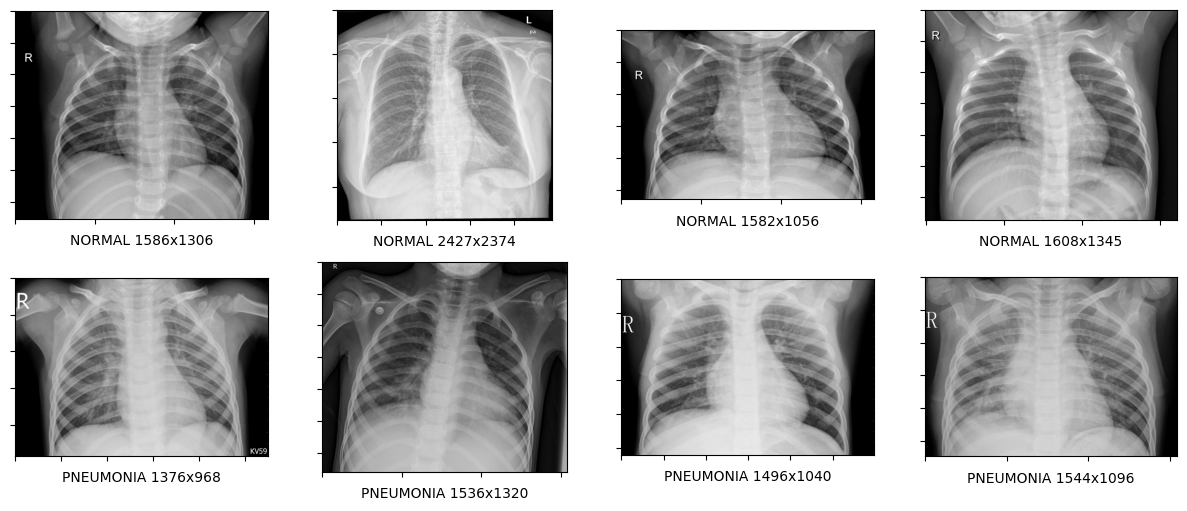

In [ ]:
#@title Dataset exploration

train_path = 'chest_xray/train'
fig = plt.figure(figsize=(15,6))

for i, folder in enumerate(os.listdir(train_path)):
    if str(folder).startswith("."): continue
    for j, img in enumerate(os.listdir(train_path+"/"+folder)):
        
        if (4*i)+j+1 > 8: break 
        
        filename = train_path+"/"+folder + "/" + img
        img= im.open(filename)
        ax = plt.subplot(2,4,(4*i)+j+1)
        ax.set_xlabel(folder+ ' '+ str(img.size[0]) +'x'+ str(img.size[1]))
        plt.imshow(img, 'gray')
        ax.set_xlabel(folder+ ' '+ str(img.size[0]) +'x'+ str(img.size[1]))
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        #plt.axis('off')
        img.close()
        if j>2:
            break

In [ ]:
#@title Image generators definition

def trainGenerator(batch_size, train_path):
    datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=5, shear_range=0.02, zoom_range=0.1,
                                       brightness_range=[0.7,1.3],  horizontal_flip=True,
                                         vertical_flip=True, fill_mode='nearest')
    
    train_gen = datagen.flow_from_directory(train_path, batch_size=batch_size,target_size=(224, 224), 
                                            shuffle=True, seed=1, class_mode="categorical" )
    for image, label in train_gen:
        yield (image, label)

def validGenerator(batch_size, valid_path):
  datagen = ImageDataGenerator(rescale=1. / 255, )
  
  valid_gen = datagen.flow_from_directory(valid_path, batch_size=batch_size, target_size=(224, 224),
                                          shuffle=True, seed=1, class_mode="categorical" )
  for image, label in valid_gen:
    yield (image, label)

In [ ]:
#@title Main model architecture
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape = (224, 224, 3), 
                   include_top = False, 
                   weights = 'imagenet')

for layer in base_model.layers[:8]:
  layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2)(x) 


model = tf.keras.models.Model(base_model.input, x)
opti = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = opti, loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics='acc')
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
#@title Main model architecture
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), 
                   include_top = False, 
                   weights = 'imagenet')

for layer in base_model.layers[:8]:
  layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2)(x) 


model = tf.keras.models.Model(base_model.input, x)
opti = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = opti, loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics='acc')
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
#@title Main model training
train_generator = trainGenerator(64,'chest_xray/train')
validation_generator = validGenerator(16,'chest_xray/test')

earlystop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks = [earlystop ]
vgg_hist = model.fit(train_generator, validation_data = validation_generator, validation_steps=10, 
                    steps_per_epoch = 64, epochs = 20, callbacks=callbacks)

Found 5232 images belonging to 2 classes.
Epoch 1/20
64/64 [==============================] - 128s 2s/step - loss: 0.3183 - acc: 0.8555 - val_loss: 0.4100 - val_acc: 0.8250
Epoch 2/20
64/64 [==============================] - 112s 2s/step - loss: 0.1372 - acc: 0.9480 - val_loss: 0.2746 - val_acc: 0.9062
Epoch 3/20
64/64 [==============================] - 102s 2s/step - loss: 0.1224 - acc: 0.9547 - val_loss: 0.1984 - val_acc: 0.9438
Epoch 4/20
64/64 [==============================] - 100s 2s/step - loss: 0.1163 - acc: 0.9532 - val_loss: 0.4161 - val_acc: 0.8750
Epoch 5/20
64/64 [==============================] - 100s 2s/step - loss: 0.0943 - acc: 0.9622 - val_loss: 0.6148 - val_acc: 0.8250
Epoch 6/20
64/64 [==============================] - 101s 2s/step - loss: 0.0790 - acc: 0.9699 - val_loss: 0.1926 - val_acc: 0.9438
Epoch 7/20
64/64 [==============================] - 101s 2s/step - loss: 0.0865 - acc: 0.9711 - val_loss: 0.2634 - val_acc: 0.9125
Epoch 8/20
64/64 [=======================

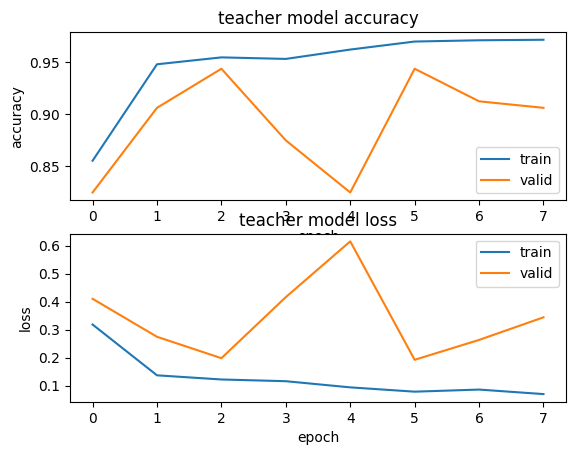

In [ ]:
#@title Main model metrics evolution

plt.figure(1)  
# summarize history for accuracy
plt.subplot(211)
plt.plot(vgg_hist.history['acc'])
plt.plot(vgg_hist.history['val_acc'])
plt.title('teacher model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(212)
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('teacher model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

Test set shape :  (624, 224, 224, 3)
20/20 [==============================] - 7s 131ms/step


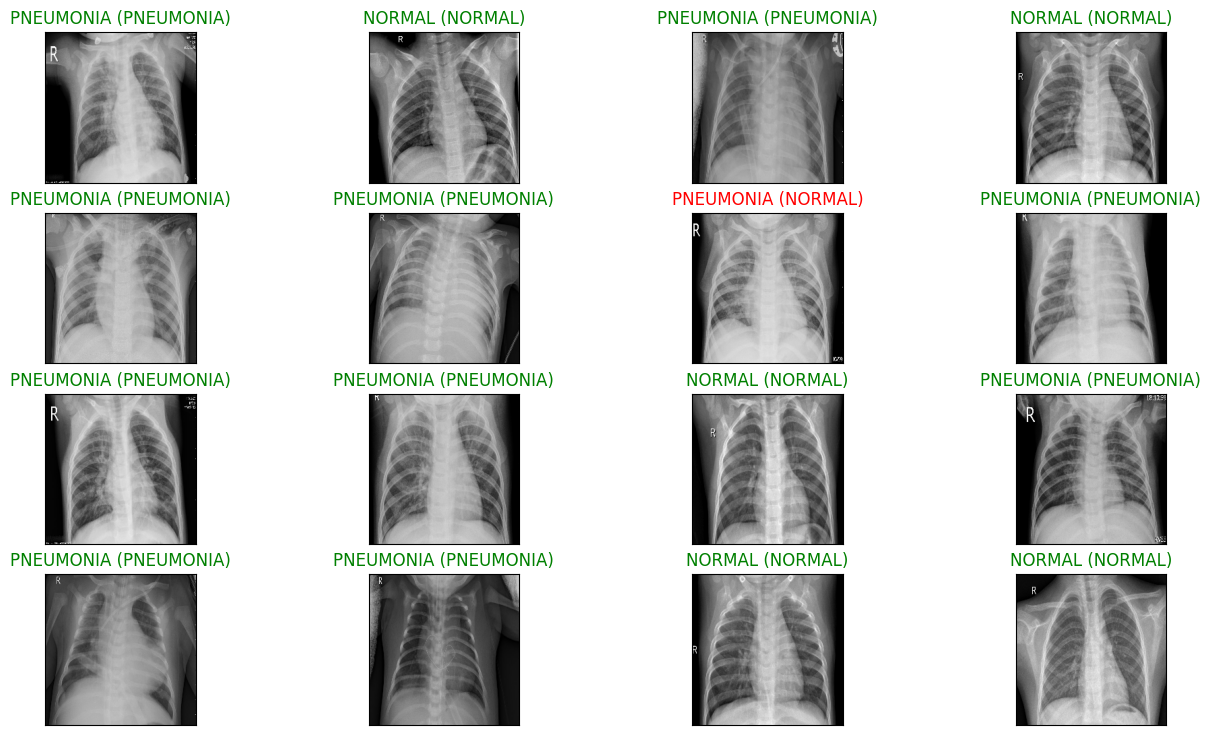

In [ ]:
#@title Model assessment

from sklearn.datasets import load_files
import numpy as np
test_dir = 'chest_xray/test'
no_of_classes = 2
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
x_test, y_test,target_labels = load_dataset(test_dir)
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)
# We just have the file names in the x set. Let's load the images and convert them into array.

from tensorflow.keras.utils import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(tf.image.resize(img_to_array(load_img(file)), (224, 224)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)
x_test = x_test.astype('float32')/255
# Let's visualize test prediction.
y_pred_logits = model.predict(x_test)
y_pred = tf.nn.softmax(y_pred_logits)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [ ]:
#@title Main model metrics

print(model.metrics_names) 
loss, acc = model.evaluate(x_test, y_test, verbose = 1)
print('test loss = ', loss) 
print('test accuracy = ',acc)

['loss', 'acc']
20/20 [==============================] - 3s 136ms/step - loss: 0.2577 - acc: 0.9263
test loss =  0.25773781538009644
test accuracy =  0.9262820482254028


In [ ]:
#@title Reduced model definition

# input
input = layers.Input(shape =(224,224,3))
# 1st Conv Block
x = layers.Conv2D (filters =8, kernel_size =3, padding ='valid', activation='relu')(input)
x = layers.Conv2D (filters =8, kernel_size =3, padding ='valid', activation='relu')(x)
x = layers.MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 2nd Conv Block
x = layers.Conv2D (filters =16, kernel_size =3, padding ='valid', activation='relu')(x)
x = layers.Conv2D (filters =16, kernel_size =3, padding ='valid', activation='relu')(x)
x = layers.MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 3rd Conv block
x = layers.Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = layers.Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = layers.MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 4th Conv block
x = layers.Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = layers.Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = layers.MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 5th Conv block
x = layers.Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = layers.Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = layers.MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# Fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(units = 256, activation ='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(units = 2)(x) 

In [ ]:
#@title Reduced model architecture

reduced_model = Model(inputs=input, outputs=output)
reduced_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2320      
                                                           

In [ ]:
#@title Reduced model training

opti = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08) # , decay=0.001)
reduced_model.compile(optimizer = opti, loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics = ['acc'])
earlystop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks = [earlystop ]
reduced_modelhist = reduced_model.fit(train_generator, validation_data = validation_generator, validation_steps=10,
                    steps_per_epoch = 64, epochs = 20, callbacks=callbacks)

Epoch 1/20
64/64 [==============================] - 97s 1s/step - loss: 0.6200 - acc: 0.7309 - val_loss: 0.6526 - val_acc: 0.6500
Epoch 2/20
64/64 [==============================] - 93s 1s/step - loss: 0.5794 - acc: 0.7432 - val_loss: 0.6448 - val_acc: 0.6562
Epoch 3/20
64/64 [==============================] - 90s 1s/step - loss: 0.5717 - acc: 0.7358 - val_loss: 0.7132 - val_acc: 0.5562
Epoch 4/20
64/64 [==============================] - 91s 1s/step - loss: 0.4844 - acc: 0.7703 - val_loss: 0.4807 - val_acc: 0.7437
Epoch 5/20
64/64 [==============================] - 92s 1s/step - loss: 0.3703 - acc: 0.8311 - val_loss: 0.3849 - val_acc: 0.8562
Epoch 6/20
64/64 [==============================] - 90s 1s/step - loss: 0.3365 - acc: 0.8452 - val_loss: 0.4416 - val_acc: 0.7875
Epoch 7/20
64/64 [==============================] - 91s 1s/step - loss: 0.2931 - acc: 0.8691 - val_loss: 0.3631 - val_acc: 0.8250
Epoch 8/20
64/64 [==============================] - 90s 1s/step - loss: 0.2542 - acc: 0.89

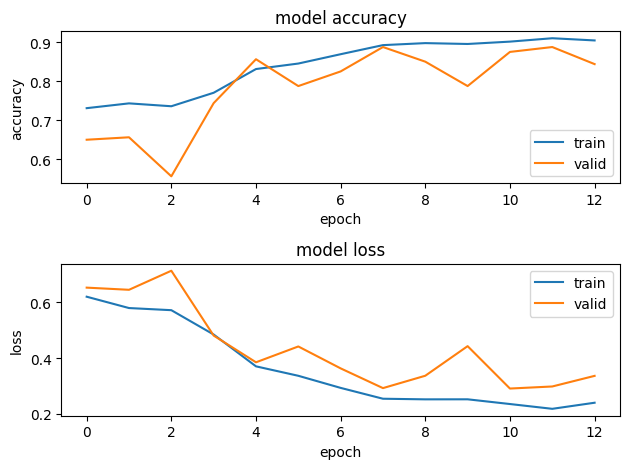

In [ ]:
#@title Reduced model metrics evaluation

plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(reduced_modelhist.history['acc'])  
plt.plot(reduced_modelhist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='lower right')  
 # summarize history for loss  
plt.subplot(212)  
plt.plot(reduced_modelhist.history['loss'])  
plt.plot(reduced_modelhist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='upper right')  
plt.tight_layout()
plt.show()

In [ ]:
#@title Reduced model metrics

print(reduced_model.metrics_names)
loss, acc = reduced_model.evaluate(x_test, y_test, verbose = 1)
print('test loss = ', loss)
print('test accuracy = ',acc)

['loss', 'acc']
20/20 [==============================] - 1s 15ms/step - loss: 0.3100 - acc: 0.8718
test loss =  0.31001096963882446
test accuracy =  0.8717948794364929


# Modelo estudiante


In [ ]:
#@title Student model definition 

student_model = Model(inputs=input, outputs=output)
student_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2320      
                                                           

In [ ]:
#@title Destiler definition 

import keras
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        # super(Distiller, self).__init__()
        super().__init__()
        self.teacher = teacher
        self.student = student
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=2,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        # super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    def train_step(self, data):
        # Unpack data
        x, y = data
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss +  distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
#@title Destiled model training

# Initialize and compile distiller
distiller = Distiller(student=student_model, teacher=model)
distiller.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08), # , decay=0.001),
    metrics=['acc'],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    #distillation_loss_fn=CategoricalCrossentropy(), 
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=6,
)
# Distill teacher to student
distiller_hist = distiller.fit(train_generator, validation_data = validation_generator, epochs=50, validation_steps=10,
              steps_per_epoch = 64)

Epoch 1/50
64/64 [==============================] - 99s 1s/step - acc: 0.9078 - student_loss: 0.2298 - distillation_loss: 0.0423 - val_acc: 0.8375 - val_student_loss: 0.0692
Epoch 2/50
64/64 [==============================] - 96s 2s/step - acc: 0.9065 - student_loss: 0.2206 - distillation_loss: 0.0380 - val_acc: 0.8562 - val_student_loss: 0.3118
Epoch 3/50
64/64 [==============================] - 94s 1s/step - acc: 0.9206 - student_loss: 0.2027 - distillation_loss: 0.0345 - val_acc: 0.8687 - val_student_loss: 0.4630
Epoch 4/50
64/64 [==============================] - 97s 2s/step - acc: 0.9174 - student_loss: 0.2118 - distillation_loss: 0.0374 - val_acc: 0.8750 - val_student_loss: 0.5997
Epoch 5/50
64/64 [==============================] - 94s 1s/step - acc: 0.9169 - student_loss: 0.2063 - distillation_loss: 0.0361 - val_acc: 0.8750 - val_student_loss: 0.2025
Epoch 6/50
64/64 [==============================] - 94s 1s/step - acc: 0.9245 - student_loss: 0.1945 - distillation_loss: 0.0328 -

In [ ]:
#@title Destiled model metrics evolution

plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(distiller_hist.history['acc'])  
plt.plot(distiller_hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='lower right')  
 # summarize history for loss  
plt.subplot(212)  
plt.plot(distiller_hist.history['student_loss'])  
plt.plot(distiller_hist.history['val_student_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='upper right')  
plt.show()
plt.tight_layout()

In [ ]:
#@title Destiled model metrics

print(distiller.metrics_names)
acc, loss = distiller.evaluate(x_test, y_test, verbose = 1) 
print('test loss = ', loss)
print('test accuracy = ',acc)

# Summary of metrics 

In [ ]:
#@title Main model metrics

print("Main model total parameters : ", f"{model.count_params():,}")

loss, acc = model.evaluate(x_test, y_test, verbose = 1)
print('test loss = ', loss) 
print('test accuracy = ',acc)

In [ ]:
#@title Reduced model metrics

print("Student model total parameters : ", f"{reduced_model.count_params():,}")

loss, acc = reduced_model.evaluate(x_test, y_test, verbose = 1)
print('test loss = ', loss)
print('test accuracy = ',acc)

In [ ]:
#@title Destiled model 2 metrics

print("Destiled model total parameters : ", f"{distiller.count_params():,}")

acc, loss = distiller.evaluate(x_test, y_test, verbose = 1) 
print('test loss = ', loss)
print('test accuracy = ',acc)

In [ ]:
#@title Destiled student model metrics

estudiante = distiller.student

print("Destiled model total parameters : ", f"{estudiante.count_params():,}")

loss, acc = estudiante.evaluate(x_test, y_test, verbose = 1)
print('test loss = ', loss)
print('test accuracy = ',acc)

In [ ]:
#@title Import model as TF.js

!pip install tensorflowjs

import tensorflowjs as tfjs 

In [ ]:
#@title Save models as TF.js

tfjs.converters.save_keras_model(model, './teacher_model/')
tfjs.converters.save_keras_model(student_model, './student_model/')